## **Fine-tuning LayoutLMv3 using the SROIE dataset**

This notebook is my attempt at fine-tuning the LayoutLM model using the SROIE dataset for information extraction. The model is presented in the paper "LayoutLM: Pre-training of Text and Layout for Document Image Understanding" by Yiheng Xu, Minghao Li, Lei Cui, Shaohan Huang, Furu Wei and Ming Zhou

# Notebook Setup

In [ ]:
!pip install transformers==4.28.0
! sudo apt install tesseract-ocr
! pip install -q pytesseract --progress-bar off
!pip install -qqq easyocr==1.6.2 --progress-bar off
!pip install -q datasets seqeval --progress-bar off
!pip install --upgrade accelerate
!pip install evaluate

In [ ]:
import numpy as np
import pandas as pd
import os
import json
import torch

import matplotlib.pyplot as plt

import cv2
import glob
from google.colab import drive
from PIL import Image, ImageDraw, ImageFont


import pytesseract
from sklearn.model_selection import train_test_split
import easyocr

from difflib import SequenceMatcher

from datasets import Dataset , load_metric,Features, Sequence, ClassLabel, Value, Array2D, Array3D
from tqdm.notebook import tqdm

from accelerate.state import PartialState
import evaluate
from transformers import LayoutLMv3ForTokenClassification ,  TrainingArguments, Trainer ,AutoProcessor,AdamW
from transformers.data.data_collator import default_data_collator


# Load Data

---




In [ ]:
df = pd.read_excel('/content/drive/MyDrive/PFE/docs content.xlsx')
df =df[df['label']=='recu'].reset_index(drop = True)


## Extract the receipts from the merged data

In [ ]:
recbox = []
for i in range(len(df)):
  recbox.append('/content/drive/MyDrive/PFE/data/SROIE2019/test/box/'+ os.path.splitext(os.path.basename(df['document'][i]))[0]+'.txt')

In [ ]:
df['box']=recbox
# df['entities']=recenti
df.drop({'Unnamed: 0','names'},axis=1,inplace=True)
df

,document,label,box
0,/content/drive/MyDrive/PFE/data/SROIE2019/test...,recu,/content/drive/MyDrive/PFE/data/SROIE2019/test...
1,/content/drive/MyDrive/PFE/data/SROIE2019/test...,recu,/content/drive/MyDrive/PFE/data/SROIE2019/test...
2,/content/drive/MyDrive/PFE/data/SROIE2019/test...,recu,/content/drive/MyDrive/PFE/data/SROIE2019/test...
3,/content/drive/MyDrive/PFE/data/SROIE2019/test...,recu,/content/drive/MyDrive/PFE/data/SROIE2019/test...
4,/content/drive/MyDrive/PFE/data/SROIE2019/test...,recu,/content/drive/MyDrive/PFE/data/SROIE2019/test...
...,...,...,...
194,/content/drive/MyDrive/PFE/data/SROIE2019/test...,recu,/content/drive/MyDrive/PFE/data/SROIE2019/test...
195,/content/drive/MyDrive/PFE/data/SROIE2019/test...,recu,/content/drive/MyDrive/PFE/data/SROIE2019/test...
196,/content/drive/MyDrive/PFE/data/SROIE2019/test...,recu,/content/drive/MyDrive/PFE/data/SROIE2019/test...
197,/content/drive/MyDrive/PFE/data/SROIE2019/test...,recu,/content/drive/MyDrive/PFE/data/SROIE2019/test...


## Prepare the data

---



In [ ]:
# read text / box / label
def receipt_content(path_txt):
  texts= []
  boxes = []
  labels = []
  entit_path=path_txt.replace('box','entities')
  with open(path_txt, 'r',encoding='latin-1') as f:
    # data of a single file
    data = f.read().splitlines()
    for line in data :
      split_lines = line.split(",")
      # boxes list
      bbox = np.array(split_lines[0:8], dtype=np.int64)
      bbox = bbox.tolist()
      boxes.append(bbox[0:3]+[bbox[-1]])
      # texts list
      text =",".join(split_lines[8:])
      texts.append(text)
      # labels list
      with open(entit_path, 'r') as fs :
        dot = json.loads(fs.read())
        ddd = pd.DataFrame.from_dict(dot,orient='index').T
      line_set=text.replace(",", "").strip().split()
      lab=''
      for i, column in enumerate(ddd):
          entity_values = ddd.iloc[0, i].replace(",", "").strip()
          entity_set = entity_values.split()

          matches_count = 0
          for l in line_set:
            if any(SequenceMatcher(a=l, b=b).ratio() >= 0.78 for b in entity_set):
              matches_count += 1
          if matches_count == len(line_set) or matches_count == len(entity_set):
            lab= "S-" + column.upper()

      if lab=='' :
            lab = "O"
      labels.append(lab)

  return texts,boxes,labels

In [ ]:
text_list = []
boxes = []
word_labels = []

  # ner_tags de tokens :
label_list=['S-ADDRESS','S-COMPANY','S-DATE','S-TOTAL','O']

id2label = {0: 'S-ADDRESS', 1: 'S-COMPANY', 2: 'S-DATE', 3: 'S-TOTAL' , 4: 'O'}
label2id = {'S-ADDRESS': 0, 'S-COMPANY': 1, 'S-DATE': 2, 'S-TOTAL': 3, 'O': 4}


for j in range(len(df)):
  text_list.append(receipt_content(df['box'][j])[0])
  boxes.append(receipt_content(df['box'][j])[1])
  word_labels.append([label2id[t] for t in receipt_content(df['box'][j])[2]])

In [ ]:
# check the type of the words

t = []
for i in range(len(text_list)):
  for j in range(len(text_list[i])):
    #  t.append(i)
      t.append(type(text_list[i][j]))
set(t)

{str}

In [ ]:
# check the type of the boxes

t = []
for i in range(len(boxes)):
  for j in range(len(boxes[i])):
    for z in range(len(boxes[i][j])):
    #  t.append(i)
      t.append(type(boxes[i][j][z]))
set(t)

{int}

In [ ]:
#features: ['tokens', 'bboxes', 'label', 'document'],
df['tokens']=text_list
df['bboxes']=boxes
df['label']=word_labels
df.drop('box',axis=1,inplace=True)
df

## Plot the distribution of entities in each document

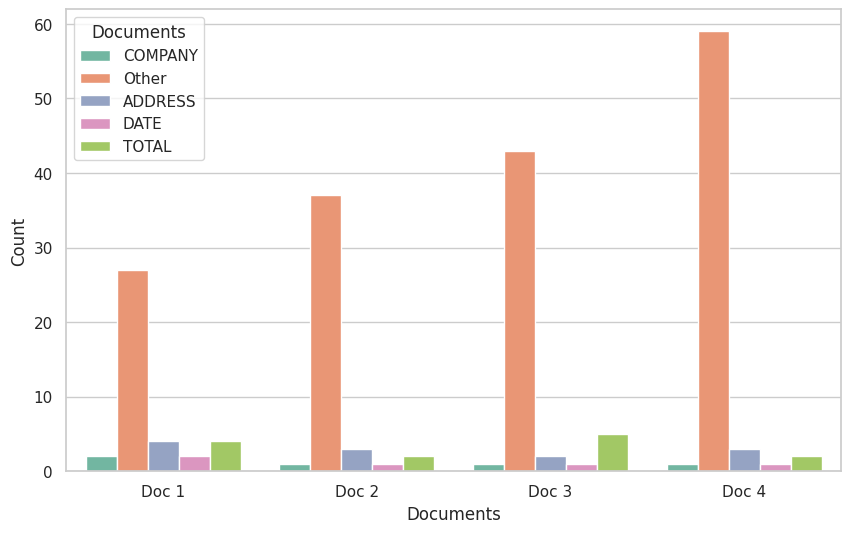

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Your list of documents
documents = df_t['label']

# Flatten the list of documents and create a corresponding list of document labels
flattened_categories = ['Doc {}'.format(i+1) for i in range(len(documents)) for _ in range(len(documents[i]))]
doc_labels = [category for doc in documents for category in doc]

# Create a Pandas DataFrame with the categories and document labels
df = pd.DataFrame({'Category': flattened_categories, 'Document': doc_labels})

df['Document'] = df['Document'].replace({0: 'ADDRESS', 1: 'COMPANY', 2: 'DATE', 3: 'TOTAL' , 4: 'Other'})

# Create a countplot
sns.set(style="whitegrid")  # Optional: Set the plot style
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
sns.countplot(data=df, x='Category', hue='Document',palette = 'Set2')

# Add labels and title
plt.xlabel('Documents')
plt.ylabel('Count')
plt.legend(title='Documents')

# Show the plot
plt.show()


## test preparation

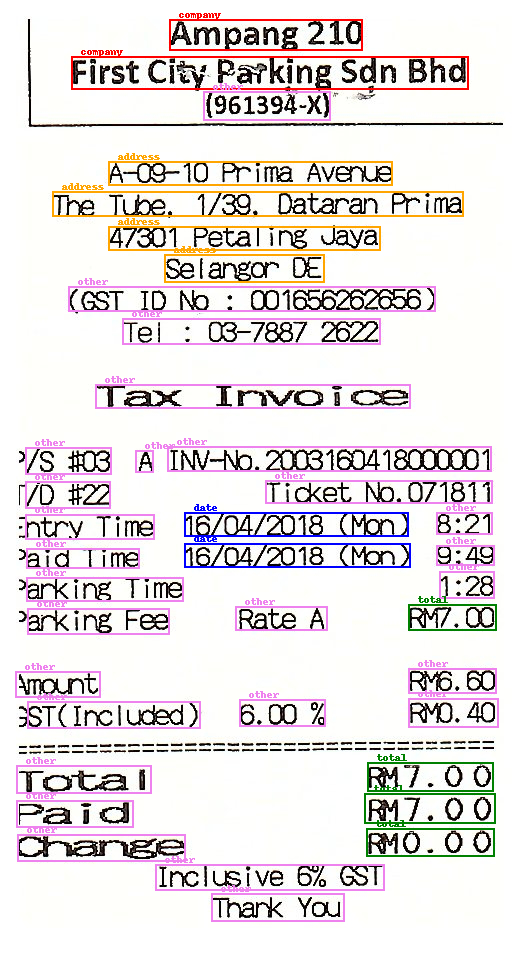

In [ ]:
image = Image.open(df['document'][0]).convert("RGB")
image
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'date':'blue', 'total':'green', 'address':'orange', 'other':'violet', 'company':'red'}

for word, box, label in zip(df['tokens'][0],df['bboxes'][0],
                          df['label'][0]):
  actual_label = iob_to_label(id2label[label]).lower()
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)
image.save("modified_image.jpg")
image


#Processing

In [ ]:
#split data
train,test,  = train_test_split(df, test_size=0.25,random_state=42)

train

,document,label,tokens,bboxes
56,/content/drive/MyDrive/PFE/data/SROIE2019/test...,"[1, 4, 0, 0, 4, 4, 4, 4, 4, 2, 4, 4, 4, 3, 4, ...","[FIVE STAR CASH & CARRY, (1365663-P), G.23 & G...","[[116, 196, 582, 224], [253, 236, 412, 266], [..."
5,/content/drive/MyDrive/PFE/data/SROIE2019/test...,"[1, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, ...","[SOUP & PORRIDGE, LOT S10NB & S12NB,, RESTORAN...","[[210, 214, 388, 237], [200, 243, 410, 268], [..."
122,/content/drive/MyDrive/PFE/data/SROIE2019/test...,"[1, 4, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, ...","[SYARIKAT PERNIAGAAN GIN KEE, (81109-A), NO 29...","[[88, 208, 839, 262], [380, 267, 543, 310], [2..."
113,/content/drive/MyDrive/PFE/data/SROIE2019/test...,"[1, 4, 0, 0, 0, 4, 4, 4, 2, 4, 3, 4, 4, 4, 4, ...","[SANJUNG REALITI SDN. BHD. (779763-K), (GST RE...","[[46, 139, 426, 166], [51, 173, 427, 199], [44..."
93,/content/drive/MyDrive/PFE/data/SROIE2019/test...,"[1, 4, 0, 0, 0, 4, 4, 4, 4, 2, 4, 3, 4, 4, 4, ...","[DION REALTIES SDN BHD (CO. NO:20154-T), (GST ...","[[48, 143, 452, 167], [46, 173, 430, 201], [47..."
...,...,...,...,...
106,/content/drive/MyDrive/PFE/data/SROIE2019/test...,"[1, 4, 0, 0, 0, 4, 4, 4, 4, 2, 4, 3, 4, 4, 4, ...","[DION REALTIES SDN BHD (CO. NO:20154-T), (GST ...","[[62, 148, 463, 175], [62, 182, 442, 209], [61..."
14,/content/drive/MyDrive/PFE/data/SROIE2019/test...,"[1, 0, 0, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 2, ...","[GARDENIA BAKERIES (KL) SDN BHD (139386 X), LO...","[[30, 67, 592, 90], [175, 89, 450, 113], [160,..."
92,/content/drive/MyDrive/PFE/data/SROIE2019/test...,"[1, 1, 4, 4, 0, 0, 4, 4, 2, 4, 4, 4, 4, 4, 4, ...","[POPULAR BOOK, CO. (M) SDN BHD, (CO. NO. 11382...","[[168, 119, 692, 184], [123, 199, 779, 270], [..."
179,/content/drive/MyDrive/PFE/data/SROIE2019/test...,"[1, 4, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[MR.D.I.Y(M)SDN BHD, CO-REG:860671-D, LOT 1851...","[[254, 373, 626, 414], [272, 420, 584, 455], [..."


In [ ]:
# read df as Datasets object
dataset = Dataset.from_pandas(train).remove_columns(["__index_level_0__"])
test_dataset = Dataset.from_pandas(test).remove_columns(["__index_level_0__"])

dataset , test_dataset

(Dataset({
     features: ['document', 'label', 'tokens', 'bboxes'],
     num_rows: 149
 }),
 Dataset({
     features: ['document', 'label', 'tokens', 'bboxes'],
     num_rows: 50
 }))

In [ ]:
df_copy=df.copy()

In [ ]:
def normalize_boxes(bbox, image):
    w, h = image.size
     # Normalize bounding box coordinates
    norm_bbox = [bbox[0]/w, bbox[1]/h, bbox[2]/w, bbox[3]/h]
     # rane [0 , 1000]
    return [
         int(1000 * norm_bbox[0]),
         int(1000 * norm_bbox[1]),
         int(1000 * norm_bbox[2]),
         int(1000 * norm_bbox[3])
     ]

In [ ]:
# Load and preprocess the input documents
def load_data(examples) :
  mimages = []
  for doc_path in examples['document']:
      img =  Image.open(doc_path).convert("RGB")
      mimages.append(img)
  return mimages

## LayoutLMv3Processor

In [ ]:
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [ ]:
def preprocess_data(examples):
  normalized_boxes=[]
  # Load and preprocess the input documents
  images = load_data(examples)
  boxes = examples['bboxes']
  for i in range(len(images)):
      normalized_boxes.append([normalize_boxes(box, images[i]) for box in boxes[i]])

  text_list = examples['tokens']
  word_labels = examples['label']

  #to pad the sequences to the same length (padding=True)
  #and truncated if they exceed the maximum sequence length  (truncation=True)
  encoded_inputs = processor(images,
                             text_list,
                             boxes=normalized_boxes,
                             word_labels=word_labels,
                             truncation=True, padding="max_length")

  return encoded_inputs

## Mapping

In [ ]:
features = Features(
{ 'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
  'input_ids': Sequence(feature=Value(dtype='int64')),
  'attention_mask': Sequence(Value(dtype='int64')),
  'bbox': Array2D(dtype="int64", shape=(512, 4)),
  'labels': Sequence(ClassLabel(names=label_list)),
 })

# batch_size : need to set a smaller batch_size to avoid running out of memory during training.
encoded_dataset= dataset.map(preprocess_data,
                              remove_columns=dataset.column_names,
                              features=features,
                              batched=True, batch_size=2
                             )

encoded_val =  test_dataset.map(preprocess_data,
                              remove_columns=dataset.column_names,
                              features=features,
                              batched=True, batch_size=2
                             )

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [ ]:
encoded_dataset , encoded_val

(Dataset({
     features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
     num_rows: 149
 }),
 Dataset({
     features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
     num_rows: 50
 }))

In [ ]:
#to return PyTorch tensors (return_tensors="pt") as the LayoutLM implementation in the Transformers library is in PyTorch.
encoded_dataset.set_format(type="torch")
#encoded_val.set_format(type="torch")

In [ ]:
example = encoded_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


# Modeling

## Define metrics


In [ ]:
metric = evaluate.load("seqeval")

In [ ]:
import numpy as np


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

## Define the model
## **✳ *TOKENS Classification* ✳**



In [ ]:
# implementation of LayoutLMv3
model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                        num_labels=len(label_list),
                                                         id2label=id2label,
                                                         label2id=label2id
                                                         )

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training

In [ ]:
training_args = TrainingArguments(output_dir="test",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset,
    eval_dataset=encoded_val,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.164130,0.830508,0.820574,0.825511,0.947902
200,No log,0.128844,0.836283,0.904306,0.868966,0.959117
300,No log,0.106019,0.884434,0.897129,0.890736,0.966715
400,No log,0.098631,0.880000,0.947368,0.912442,0.972504
500,0.149600,0.104258,0.895216,0.940191,0.917153,0.974313
600,0.149600,0.099310,0.895455,0.942584,0.918415,0.974674
700,0.149600,0.110215,0.901376,0.940191,0.920375,0.975398
800,0.149600,0.111770,0.911628,0.937799,0.924528,0.976845
900,0.149600,0.117140,0.911833,0.940191,0.925795,0.977207
1000,0.026800,0.118051,0.909931,0.942584,0.925969,0.977207


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


TrainOutput(global_step=1000, training_loss=0.08820601272583008, metrics={'train_runtime': 534.1132, 'train_samples_per_second': 3.745, 'train_steps_per_second': 1.872, 'total_flos': 523774428951552.0, 'train_loss': 0.08820601272583008, 'epoch': 13.33})

In [ ]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'eval_loss': 0.11805135756731033,
 'eval_precision': 0.9099307159353349,
 'eval_recall': 0.9425837320574163,
 'eval_f1': 0.9259694477085783,
 'eval_accuracy': 0.9772069464544139,
 'eval_runtime': 5.6162,
 'eval_samples_per_second': 8.903,
 'eval_steps_per_second': 4.451,
 'epoch': 13.33}